In [70]:
import numpy as np
import pandas as pd
import time
import pandas_datareader as pdr

import keras
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers.wrappers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout

from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt

In [71]:
df = pd.read_csv("/kaggle/input/time-series-forecasting-with-yahoo-stock-price/yahoo_stock.csv")
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1825 non-null   object 
 1   High       1825 non-null   float64
 2   Low        1825 non-null   float64
 3   Open       1825 non-null   float64
 4   Close      1825 non-null   float64
 5   Volume     1825 non-null   float64
 6   Adj Close  1825 non-null   float64
dtypes: float64(6), object(1)
memory usage: 99.9+ KB


In [73]:
df["Date"] = pd.to_datetime(df["Date"])
df["Date"]

0      2015-11-23
1      2015-11-24
2      2015-11-25
3      2015-11-26
4      2015-11-27
          ...    
1820   2020-11-16
1821   2020-11-17
1822   2020-11-18
1823   2020-11-19
1824   2020-11-20
Name: Date, Length: 1825, dtype: datetime64[ns]

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1825 non-null   datetime64[ns]
 1   High       1825 non-null   float64       
 2   Low        1825 non-null   float64       
 3   Open       1825 non-null   float64       
 4   Close      1825 non-null   float64       
 5   Volume     1825 non-null   float64       
 6   Adj Close  1825 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 99.9 KB


In [75]:
df["Date"].min(), df["Date"].max()

(Timestamp('2015-11-23 00:00:00'), Timestamp('2020-11-20 00:00:00'))

In [76]:
df.set_index("Date",inplace=True)
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


Text(0.5, 1.0, 'Plotting Price against the Entire Timeframe For all the columns')

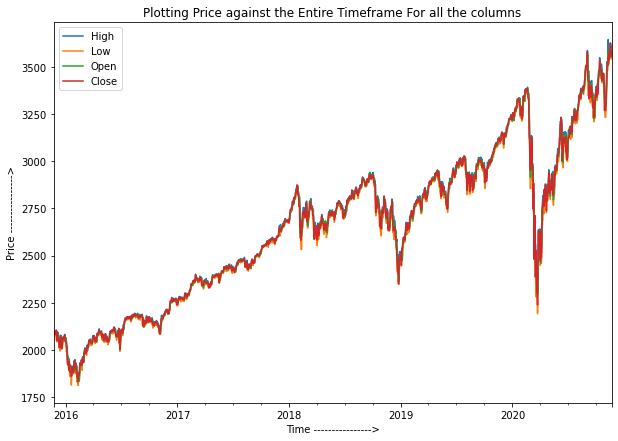

In [77]:
df[["High", "Low", "Open", "Close"]].plot(figsize=(10,7))
plt.legend(loc="best")
plt.xlabel("Time ---------------->")
plt.ylabel("Price ---------------->")
plt.title("Plotting Price against the Entire Timeframe For all the columns")

Text(0.5, 1.0, 'Plotting Price against the Entire Timeframe For HIGH column')

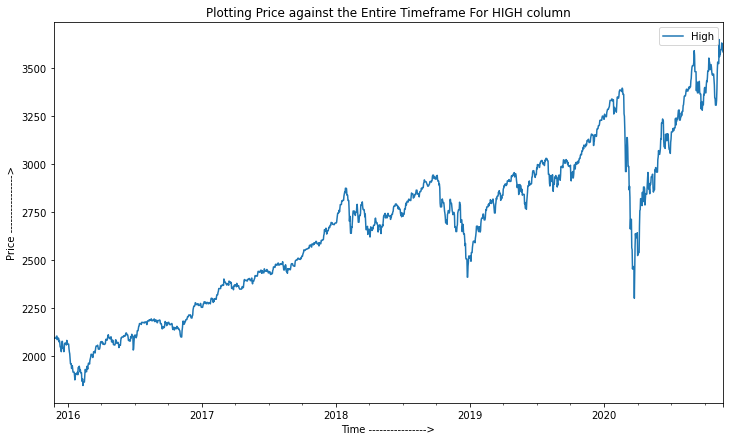

In [78]:
plt.figure(figsize=(12,7))
df["High"].plot()
plt.legend(loc="best")
plt.xlabel("Time ---------------->")
plt.ylabel("Price ---------------->")
plt.title("Plotting Price against the Entire Timeframe For HIGH column")

In [79]:
new_df = pd.DataFrame(df["High"].copy(), columns=["High"])
new_df.head()

,High
Date,
2015-11-23,2095.610107
2015-11-24,2094.120117
2015-11-25,2093.000000
2015-11-26,2093.000000
2015-11-27,2093.290039


In [80]:
train_size = int(len(new_df)*0.8)

train = new_df.iloc[0:train_size]
test = new_df.iloc[train_size:len(new_df)]

In [81]:
len(train), len(test)

(1460, 365)

In [82]:
def create_dataset(X, y, lag=1):
    xs,ys = [], []
    
    for i in range(len(X) - lag):
        tmp = X.iloc[i: i+lag].values
        xs.append(tmp)
        ys.append(y.iloc[i+lag])
    
    return np.array(xs), np.array(ys)

In [83]:
xtrain, ytrain = create_dataset(train, train["High"],10)
xtest, ytest = create_dataset(test, test["High"],10)

In [84]:
xtrain[0]

array([[2095.61010742],
       [2094.12011719],
       [2093.        ],
       [2093.        ],
       [2093.29003906],
       [2093.29003906],
       [2093.29003906],
       [2093.81005859],
       [2103.37011719],
       [2104.27001953]])

In [85]:
ytrain[0]

2085.0

**LSTM Model Applied**

In [86]:
model = Sequential()
model.add(LSTM(50,activation='relu', input_shape=(xtrain.shape[1], xtrain.shape[2])))
model.add(Dense(35))
model.add(Dense(20))
model.add(Dense(10))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")

In [87]:
model.fit(xtrain, ytrain,
         epochs=10,
         batch_size=10,
         verbose=1,
         shuffle=False
         )

Epoch 1/10
145/145 [==============================] - 2s 6ms/step - loss: 24354.4961
Epoch 2/10
145/145 [==============================] - 1s 6ms/step - loss: 2954.8772
Epoch 3/10
145/145 [==============================] - 1s 6ms/step - loss: 1815.8651
Epoch 4/10
145/145 [==============================] - 1s 6ms/step - loss: 1167.9244
Epoch 5/10
145/145 [==============================] - 1s 6ms/step - loss: 1457.8481
Epoch 6/10
145/145 [==============================] - 1s 5ms/step - loss: 1884.4673
Epoch 7/10
145/145 [==============================] - 1s 6ms/step - loss: 2521.7139
Epoch 8/10
145/145 [==============================] - 1s 6ms/step - loss: 2219.7373
Epoch 9/10
145/145 [==============================] - 1s 5ms/step - loss: 2178.3137
Epoch 10/10
145/145 [==============================] - 1s 7ms/step - loss: 2160.3660


In [88]:
ypred = model.predict(xtest)

Text(0.5, 1.0, 'Plotting Predicted And Actual Values Together against the Entire Timeframe')

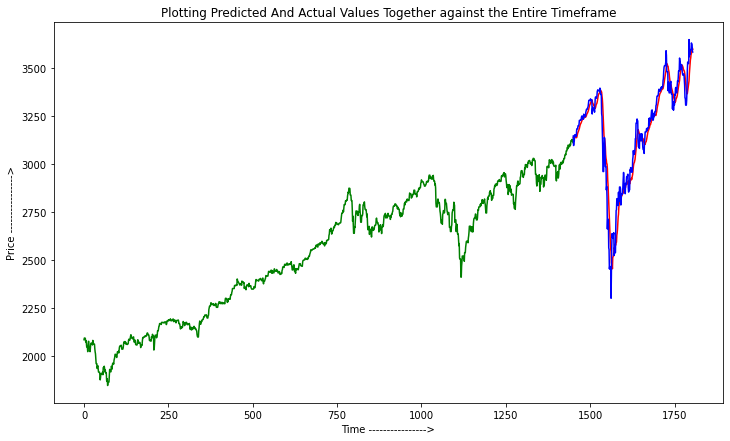

In [89]:
plt.figure(figsize=(12,7))
plt.plot(np.arange(0, len(xtrain)), ytrain, 'g', label="history")
plt.plot(np.arange(len(xtrain), len(xtrain) + len(xtest)), ypred, 'r', label="predictions")
plt.plot(np.arange(len(xtrain), len(xtrain) + len(xtest)), ytest, 'b', label="Actual")
plt.xlabel("Time ---------------->")
plt.ylabel("Price ---------------->")
plt.title("Plotting Predicted And Actual Values Together against the Entire Timeframe")

In [90]:
from sklearn.metrics import mean_squared_error
mean_squared_error(ytest, ypred,squared=False)

74.97625585466112

In [91]:
from sklearn import metrics
from sklearn.metrics import r2_score
score = r2_score(ytest, ypred)
100*score

92.0585614679787

Text(0.5, 1.0, 'Plotting Predicted And Actual Values Together against the Testing Timeframe')

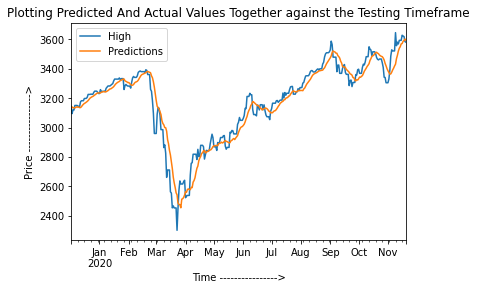

In [92]:
test = new_df.iloc[train_size+10:].copy()

test["Predictions"] = ypred
test[["High", "Predictions"]].plot()
plt.xlabel("Time ---------------->")
plt.ylabel("Price ---------------->")
plt.title("Plotting Predicted And Actual Values Together against the Testing Timeframe")

Observation:
1. Increment of neural layers with number of neurons, increasing efficiency